# Results
In this notebook we will learn the following about the Results class returned a Benchmark evaluation:
1. **Result Creation**: How to create Results from a Benchmark and Learners.
2. **Result Plotting**: How to create plots of the learners that were evaluted by a benchmark
3. **Result Saving/Loading**: How to save and load results to and from disk
4. **Result to Pandas**: How to turn Result into a collection of Pandas dataframes for more in-depth analysis

## Result Creation

**Results** are created whenever Learners are evaluated on a Benchmark. Below is a simple example of this:

In [1]:
from coba.simulations import ValidationSimulation
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

result = Benchmark([ValidationSimulation(1000)]).evaluate([RandomLearner(), VowpalLearner(epsilon=0.1)])

2021-06-25 18:37:59 Processing chunk...
2021-06-25 18:37:59   * Creating source 0 from ValidationSimulation(cf=True,af=True,seed=1000)... (0.0 seconds)
2021-06-25 18:37:59   * Creating simulation 0 from source 0... (0.0 seconds)
2021-06-25 18:38:00   * Evaluating learner 1 on Simulation 0... (0.36 seconds)
2021-06-25 18:38:00   * Evaluating learner 0 on Simulation 0... (0.04 seconds)


## Result Plotting

The **Result** class is capable of creating two separate plots: 1) `plot_learners` and `plot_shuffles`. 

### Plot Learners
Perhaps the most straightforward question after running a Benchmark is asking which Learners performed best.

To answer this question the **Result** has a `plot_learners` method.

2021-06-25 18:57:57 Processing chunk...
2021-06-25 18:57:57   * Creating source 0 from ValidationSimulation(cf=True,af=True,seed=1000)... (0.0 seconds)
2021-06-25 18:57:57   * Creating simulation 0 from source 0... (0.0 seconds)
2021-06-25 18:57:58   * Evaluating learner 1 on Simulation 0... (0.35 seconds)
2021-06-25 18:57:58   * Evaluating learner 0 on Simulation 0... (0.04 seconds)
2021-06-25 18:57:58   * Creating simulation 1 from source 0... (0.0 seconds)
2021-06-25 18:57:58   * Evaluating learner 1 on Simulation 1... (0.38 seconds)
2021-06-25 18:57:58   * Evaluating learner 0 on Simulation 1... (0.04 seconds)
2021-06-25 18:57:58   * Creating simulation 2 from source 0... (0.0 seconds)
2021-06-25 18:57:58   * Evaluating learner 1 on Simulation 2... (0.37 seconds)
2021-06-25 18:57:58   * Evaluating learner 0 on Simulation 2... (0.04 seconds)
2021-06-25 18:57:58   * Creating simulation 3 from source 0... (0.0 seconds)
2021-06-25 18:57:59   * Evaluating learner 1 on Simulation 3... (0

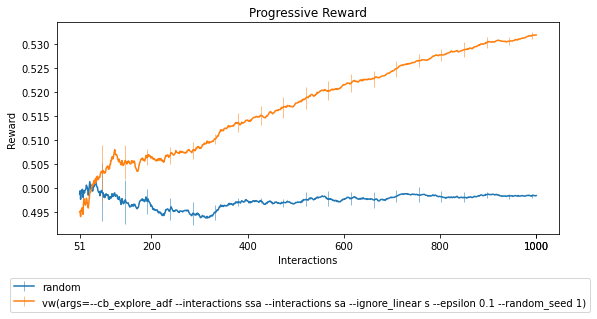

In [13]:
from coba.simulations import ValidationSimulation
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

result = Benchmark([ValidationSimulation(1000)], shuffle=[1,2,3,4]).evaluate([RandomLearner(), VowpalLearner(epsilon=0.1)])

result.plot_learners()

The `plot_learners` method has many arguments which allow customization of the plot.
```python
"""
Args:
    source_pattern: The pattern to match when determining which simulations to include in the plot. The "source" 
        matched against is either the "source" column in the simulations table or the first item in the list in 
        the simulation 'pipes' column. The simulations can be seen most easily by Result.simulations.to_pandas().
    learner_pattern: The pattern to match against the 'full_name' column in learners to determine which learners
        to include in the plot. In the case of multiple matches only the last match is kept. The learners table in
        Result can be examined via result.learners.to_pandas().
    span: In general this indicates how many previous evaluations to average together. In practice this works
        identically to ewm span value in the Pandas API. Additionally, if span equals None then all previous 
        rewards are averaged together and that value is plotted. Compare this to span = 1 WHERE only the current 
        reward is plotted for each interaction.
    start: Determines at which interaction the plot will start at. If start is greater than 1 we assume start is
        an interaction index. If start is less than 1 we assume start is the percent of interactions to skip
        before starting the plot.
    err_every: Determines frequency of bars indicating the standard deviation of the population should be drawn. 
        Standard deviation gives a sense of how well the plotted average represents the underlying distribution. 
        Standard deviation is most valuable when plotting against multiple simulations. If plotting against a single 
        simulation standard error may be a more useful indicator of confidence. The value for sd_every should be
        between 0 to 1 and will determine how frequently the standard deviation bars are drawn.
    err_type: Determines what the error bars are. Valid types are `None`, 'se', and 'sd'. If err_type is None then 
        plot will use SEM when there is only one source simulation otherwise it will use SD. Otherwise plot will
        display the standard error of the mean for 'se' and the standard deviation for 'sd'.
"""
```

For example, we can examine learner performance at the end of the Benchmark and compare smoothed reward to their instantaneous reward.

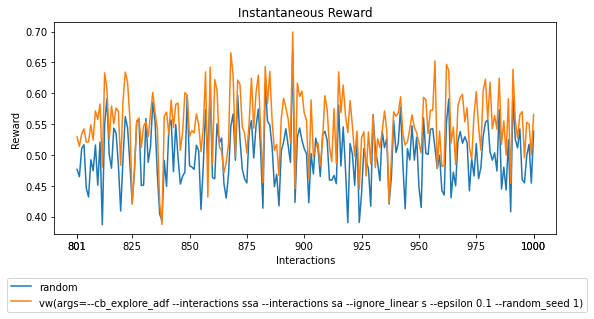

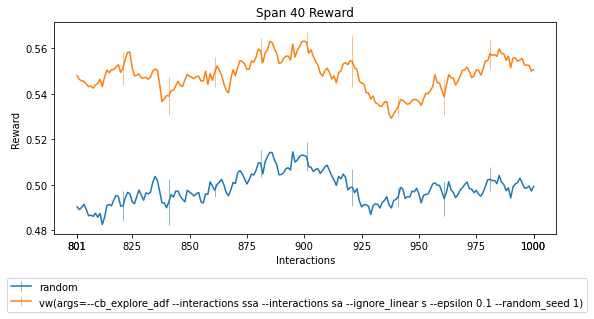

In [20]:
result.plot_learners(start=0.8, end=1.0, span=1 , err_every=0                 )
result.plot_learners(start=0.8, end=1.0, span=40, err_every=0.1, err_type='se')

### Plot Shuffles
In addition to plotting average Learner performance we can also zoom in on a single learner and superimpose its average performance on top of each of the individual shuffles that we included in our Benchmark. In our current results we have 4 shuffle seeds so there are four different performance results which are averaged together.

The `plot_shuffles` command has all the same arguments are `plot_learners`. Additionally, `plot_shuffles` assumes there's only one source of shuffles and one learner. For this reason you should pass in a source pattern and a learner pattern if there are multiple learners or simulation sources contained in the result.

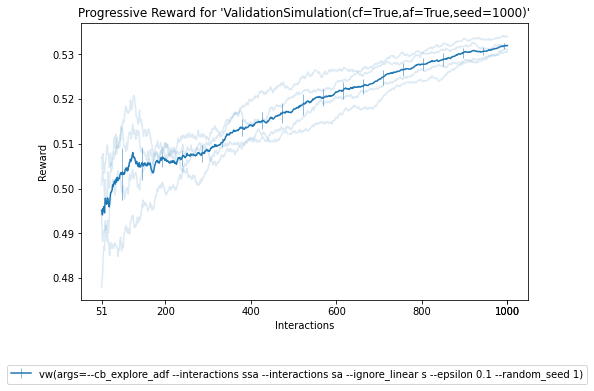

In [22]:
result.plot_shuffles(learner_pattern=".*vw.*")

## Result Saving/Loading
Saving and restoring a **Result** is the easiest way to archive and share results with others. 

Saving is done via Benchmark `evaluation`. The following code block will save the Result of the benchmark evaluation in result.log

In [34]:
from coba.simulations import ValidationSimulation
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

simulations = [ValidationSimulation()          ]
learners    = [RandomLearner(), VowpalLearner()]

result = Benchmark(simulations, shuffle=[1,2,3]).evaluate(learners, "result.log")

2021-06-25 20:01:45 Processing chunk...
2021-06-25 20:01:45   * Creating source 0 from ValidationSimulation(cf=True,af=True,seed=1000)... (0.0 seconds)
2021-06-25 20:01:45   * Creating simulation 0 from source 0... (0.0 seconds)
2021-06-25 20:01:45   * Evaluating learner 1 on Simulation 0... (0.23 seconds)
2021-06-25 20:01:45   * Evaluating learner 0 on Simulation 0... (0.03 seconds)
2021-06-25 20:01:45   * Creating simulation 1 from source 0... (0.0 seconds)
2021-06-25 20:01:45   * Evaluating learner 1 on Simulation 1... (0.23 seconds)
2021-06-25 20:01:45   * Evaluating learner 0 on Simulation 1... (0.02 seconds)
2021-06-25 20:01:45   * Creating simulation 2 from source 0... (0.0 seconds)
2021-06-25 20:01:45   * Evaluating learner 1 on Simulation 2... (0.23 seconds)
2021-06-25 20:01:45   * Evaluating learner 0 on Simulation 2... (0.03 seconds)


After a result has been saved it can be restored using `Result.from_file`. 

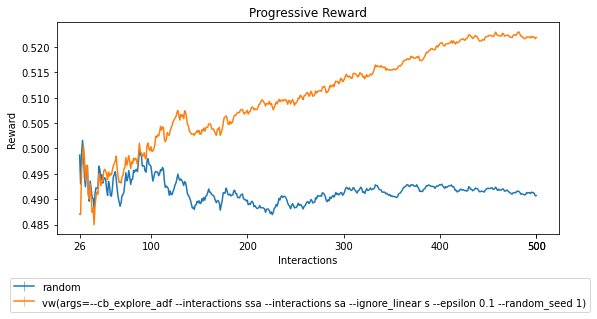

In [26]:
from coba.benchmarks import Result
Result.from_file('result.log').plot_learners()

## Result To Pandas

Finally, if the plotting functionality just shared isn't enough it is possible to extract all the data stored in Result into dataframes.

In [35]:
from coba.benchmarks import Result
Result.from_file('result.log').simulations.to_pandas()

,simulation_id,source,shuffle,take,pipe
0,0,"ValidationSimulation(cf=True,af=True,seed=1000)",1,None,"ValidationSimulation(cf=True,af=True,seed=1000..."
1,1,"ValidationSimulation(cf=True,af=True,seed=1000)",2,None,"ValidationSimulation(cf=True,af=True,seed=1000..."
2,2,"ValidationSimulation(cf=True,af=True,seed=1000)",3,None,"ValidationSimulation(cf=True,af=True,seed=1000..."


In [37]:
from coba.benchmarks import Result
Result.from_file('result.log').learners.to_pandas()

,learner_id,full_name,family,args
0,0,random,random,NaN
1,1,vw(args=--cb_explore_adf --interactions ssa --...,vw,--cb_explore_adf --interactions ssa --interact...


In [38]:
from coba.benchmarks import Result
Result.from_file('result.log').interactions.to_pandas()

,simulation_id,learner_id,index,C,A,N,reward
0,0,1,1,10,6,1,0.48114
1,0,1,2,10,9,1,0.60709
2,0,1,3,10,2,1,0.48135
3,0,1,4,10,3,1,0.51245
4,0,1,5,10,8,1,0.58319
...,...,...,...,...,...,...,...
2995,2,0,496,10,2,1,0.60834
2996,2,0,497,10,3,1,0.62901
2997,2,0,498,10,2,1,0.43394
2998,2,0,499,10,7,1,0.35947
